In [16]:
#########################
### import statements ###
#########################
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import pickle
import time
import matplotlib.animation as animation
from scipy.optimize import fsolve
import pdb
import multiprocessing
# import itertools

##############################
### global plot parameters ###
##############################
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

# Functions

In [3]:
#########################
### Analytic Spectrum ###
#########################
def ODFFHam(t,v,k):
    """
    Exact single particle spectrum.
    """
    return - 2 * t * np.cos( k ) + v

#########################################################################
### Equal-time one-body density matrix; equlibrium & zero temperature ###
#########################################################################
def C(i,j,k,P):
    '''
    Single particle pure state correlations. Essentially computes overlap between
    wavefunctions of particles at sites i and j.

    i,j: site indices; integer
    k: eigenvalue index; integer
    P: matrix of eigenstate coefficients
    '''
    C = P[k][j] * P[k][i]
    return C

def NC(i,j,nk,P):
    '''
    Calculates N-particle correlation function using single-particle pure state corre-
    lation function defined above. 

    i,j: site indices; integer
    nk: list of 0's and 1's; represents eigenstate in energy occupation basis;
        ordered according to that representation
    P: matrix of eigenstate coefficients
    '''
    NC = []
    k = 0
    for n in nk:
        NC.append(n*C(i,j,k,P))
        k += 1
    return sum(NC)

def NC2(nk,U):
    """ 
    Calculates total correlation matrix for a given initial state specified by an occupation
    representation nk. 

    nk: list of 0's and 1's; represents eigenstate in energy occupation basis;
        ordered according to that representation. MUST be a numpy array.
    U: matrix of eigenstate coefficients; matrix of eigenvectors
    """
    idx = np.where(nk == 1)
    P = U[idx]
    return np.matmul(P.T,P)


############################################################################
### Equal-time one-body density matrix; nonequlibrium & zero temperature ###
############################################################################
def SPOverlap2(wf1,mode1,wf2,mode2):
    """
    L: number of sites
    wf1,wf2: LxL matrix of eigenvectors; also called U matrix
    mode1,mode2: relevant eigenenergy mode number
    """
    return np.sum(np.conj(wf1[mode1]) * wf2[mode2])
    

def SlaterMatN(N,qs,gs):
    """
    N: number of particles; if L is even, this should be odd
        and vice versa--avoids degenerate ground states. This
        is necessary when using numeric eigenstates.
    qs: quenched state; list of L entries
    gs: ground state; list of L entries
    mode: list of N integers corresponding tot e
    """
    S = np.zeros((N,N),dtype=np.float64)
    for i in range(N):
        for j in range(N):
            S[i,j] = SPOverlap2(qs,j,gs,i)
    
    return S

def GaussianMat(N,wf1,wf2,E2,t):
    """
    Construct P matrix of Guassian states.

    N: number of particles
    wf1: matrix of pre-quench states, should be a row matrix
    wf2: matrix of post-quench states, should be a row matrix
    E2: array of post-quench energy eigenvalues
    t: time

    NOTE: information about the total number of sites L should be 
    contained within wf1,wf2, and E2. 
    """
    P = wf1[:N].T # we want P to be a column matrix, hence .T
    U = wf2.T
    z = E2*complex(0,t) # np.array([complex(0,E2[j]*t) for j in range(len(E2))])
    D = np.diag(np.exp(z))
    P1 = np.matmul(np.conj(U.T),P)
    P2 = np.matmul(D,P1)
    P3 = np.matmul(U,P2)
    return P3

def NCorrMat(P):
    """
    Calculatte the N-body correlation matrix by exploiting the 
    properties of Slater determinants and fermionic gaussian
    states.

    P: GaussianMat(N,sf1,wf2,E2,t)
    """
    Correlation = np.matmul(P,np.conj(P.T))
    return Correlation



###########################################################################
### Equal-time one-body density matrix; equlibrium & finite temperature ###
###########################################################################
def FermiEnergy(E,N):
    """
    Calculate Fermi energy of N non-interacting spinless fermions on a lattice of
    L sites. 

    E: list of L eigenvalues
    N: number of fermions; N<L
    """
    return np.sum(E[:N])


def PartitionFunc(L,beta,E,mu):
    """ 
    Calculate N-body correlation function in equilibrium at a finite temperature.

    L: size of lattice; integer
    beta: inverse temperature; float
    E: List of L eigenvalues
    mu: chemical potential; float
    """
    return np.prod(np.ones(L)+np.exp(-beta*(E-mu)))

# def PartitionFunc2(L,beta,E,mu):
#     """ 
#     Calculate N-body correlation function in equilibrium at a finite temperature.

#     L: size of lattice; integer
#     beta: inverse temperature; float
#     E: List of L eigenvalues
#     mu: chemical potential; float
#     """
#     I = np.identity(L)
#     return np.linalg.det(I+np.diag(np.exp(-beta*(E-mu))))

def NCorrFiniteT(i,j,L,beta,U,E,mu):
    """ 
    Calculate N-body correlation function in equilibrium at a finite temperature.

    i,j: site indices; integer
    L: size of lattice; integer
    beta: inverse temperature; float
    U: LxL diagonalization transformation matrix from lattice-site to energy basis
    E: List of L eigenvalues
    mu: chemical potential; float
    """
    Z = PartitionFunc(L,beta,E,mu)
    Delta = np.identity(L)
    Delta[i][j] = 1
    I = np.identity(L)
    D = np.diag(np.exp(-beta*(E-mu)))
    D1 = np.matmul(D,np.conj(U.T))
    D2 = np.matmul(U,D1)
    A = I + np.matmul(Delta,D2)
    return np.linalg.det(A) / Z - 1

def NCorrFiniteTDiag(L,beta,U,E,mu):
    """ 
    Calculate N-body correlation function in equilibrium at a finite temperature.

    i,j: site indices; integer
    L: size of lattice; integer
    beta: inverse temperature; float
    U: LxL diagonalization transformation matrix from lattice-site to energy basis
    E: List of L eigenvalues
    mu: chemical potential; float
    """
    I = np.identity(L)
    D = np.linalg.inv(I + np.diag(np.exp(-beta*(E-mu))))
    D1 = np.matmul(D,U)
    D2 = np.matmul(np.conj(U.T),D1)
    return I - D2

def GetChemicalPotential(L,N,beta,U,E):
    """ 
    Returns best fit for chemical potential given a temperature beta.
    NOTE: This function is not fast.

    L: number of sites
    N: total number of particles
    beta: inverse temperature
    U: unitary diagonalization matrix
    E: List of L eigenvalues
    """
    func = lambda mu: np.sum(np.diag(NCorrFiniteTDiag(L,beta,U,E,mu))) - N
    mu_guess = max(E[:N])
    return fsolve(func,mu_guess)

def FermiDirac(beta,mu,t,v,k):
    ''' 
    Thermal distribution for fermions on a lattive with chemical potential mu. 

    beta: inverse temperature
    mu: chemical potential
    t: hopping parameter
    v: constant on-site potential
    k: quasi-momentum
    '''
    return 1/(np.exp(beta*(ODFFHam(t,v,k)-mu))+1)

def nk(k,L,NCorr):
    ''' 
    Calculate local number density as a function of quasi-momentum.

    k: quasi-momentum number.
    i,j: site indices; integer
    L: size of lattice; integer
    beta: inverse temperature; float
    U: LxL diagonalization transformation matrix from lattice-site to energy basis
    E: List of L eigenvalues
    mu: chemical potential; float
    '''
    sites = np.linspace(0,L-1,L)
    dumvec = L**(-1/2)*np.exp(k*sites*complex(0,1)).reshape(1,L)
    eik = np.matmul(np.conj(dumvec.T),dumvec)
    nk = np.sum(eik*NCorr)
    return nk 



##############################################################################
### Equal-time one-body density matrix; nonequlibrium & finite temperature ###
##############################################################################
def pij(t,T,mu,L,U1,U2,E1,E2):
    """
    Calculate equal-time one-body density matrix at a time t after a quench
    for a system initially at a finite temperature inv(T).

    t: time; float; units of hbar/J 
    T: inverse temperature; float; units of 1/J
    mu: pre-quench chemical potental; float; units of J
    L: number of lattice sites; integer; dimensionless
    U1: matrix of pre-quench eigenvectors; LxL array of floats; dimensionless
    U2: matrix of post-quench eigenvectors; LxL array of floats; dimensionless
    E1: array of pre-quench eigenvalues; Lx1 array of floats; units of J
    E2: array of pre-quench eigenvalues; Lx1 array of floats; units of J
    """
    C0 = NCorrFiniteTDiag(L,T,U1,E1,mu)
    D = np.diag(np.exp(complex(0,1)*E2*t))
    D1 = np.matmul(D,U2)
    D2 = np.matmul(np.conj(U2).T,D1)
    C1 = np.matmul(C0,D2)
    C2 = np.matmul(np.conj(D2),C1)
    return C2

# def eik(L):
#     """ 
#     Makes a ((L,L),L) tensor which contains all possible exp(ik(i-j)) for all L values of k 
#     given k lattice sites.
#     """
#     sites = np.linspace(0,L-1,L)
#     eik = []
#     for k in np.linspace(-np.pi,np.pi,L+1):
#         eik.append(np.matmul(np.conj(L**(-1/2)*np.exp(k*sites*complex(0,1)).reshape(1,L).T),L**(-1/2)*np.exp(k*sites*complex(0,1)).reshape(1,L)))
#     return eik

def nkt(k,L,NCorr):
    ''' 
    Calculate local number density as a function of quasi-momentum, temperature, and time.

    k: quasi-momentum number.
    i,j: site indices; integer
    L: size of lattice; integer
    beta: inverse temperature; float
    time: time; float; units of hbar/J
    U1: matrix of pre-quench eigenvectors; LxL array of floats; dimensionless
    E1: array of pre-quench eigenvalues; Lx1 array of floats; units of J
    U2: matrix of post-quench eigenvectors; LxL array of floats; dimensionless
    E2: array of pre-quench eigenvalues; Lx1 array of floats; units of J
    mu: chemical potential; float
    '''
    sites = np.linspace(0,L-1,L)
    dumvec = L**(-1/2)*np.exp(k*sites*complex(0,1)).reshape(1,L)
    eik = np.matmul(np.conj(dumvec.T),dumvec)
    nk = np.sum(eik*NCorr)
    return nk

# Spectrum and Eigenstates

### Exact single-particle specrum

In [ ]:
# t = 1
# v = 0.1
# k = np.linspace(-np.pi,np.pi,101)
# plt.plot(k,ODFFHam(t,v,k),marker='.',color='black')
# plt.ylabel(r'$\epsilon_{k}$',fontsize=16)
# plt.xlabel(r'$ka$',fontsize=16)
# plt.tick_params(labelsize=16)

### Numerical single-particle spectrum -- v=cte.

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_eigval_t=1_v=0.1_g=0_L=100.txt')
eigenvectors = np.loadtxt('ODFF_eigvec_t=1_v=0.1_g=0_L=100.txt').T # .T yields a matrix of row vectors
sites = np.linspace(0,len(eigenvectors[0]),len(eigenvectors[0]))

#########################
### plot eigenvectors ###
#########################
for i in range(5):
    plt.plot(sites,np.abs(eigenvectors[i])**2,label='E'+str(i))
plt.xlabel('sites (i)',fontsize=16)
plt.ylabel(r'$\left| \psi_{k}(x_{i}) \right|^2$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,bbox_to_anchor=(1,1.2),frameon=False)

### Numerical single-particle spectrum -- v=random

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_eigval_t=1_v=0.1_g=0.1.txt')
eigenvectors = np.loadtxt('ODFF_eigvec_t=1_v=0.1_g=0.1.txt').T # .T yields a matrix of row vectors
sites = np.linspace(0,len(eigenvectors[0]),len(eigenvectors[0]))

#########################
### plot eigenvectors ###
#########################
for i in range(31):
    plt.plot(sites,np.abs(eigenvectors[i])**2,label='E'+str(i))
plt.xlabel('sites (i)',fontsize=16)
plt.ylabel(r'$\left| \psi_{k}(x_{i}) \right|^2$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,bbox_to_anchor=(1,1.45),frameon=False)

### Numerical single-particle spectrum -- v=shift

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=1_L=1000.txt')
eigenvectors = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=1_L=1000.txt').T # .T yields a matrix of row vectors
sites = np.linspace(0,len(eigenvectors[0]),len(eigenvectors[0]))

#########################
### plot eigenvectors ###
#########################
for i in range(5):
    plt.plot(sites,np.abs(eigenvectors[i])**2,label='E'+str(i))
plt.xlabel('sites (i)',fontsize=16)
plt.ylabel(r'$\left| \psi_{k}(x_{i}) \right|^2$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,bbox_to_anchor=(1,1.1),frameon=False)

# Equal-time one-particle pure-state correlations -- equilibrium

### case: v=constant

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_eigval_t=1_v=0_g=0.txt')
eigenvectors = np.loadtxt('ODFF_eigvec_t=1_v=0_g=0.txt').T # .T yields a matrix of row vectors
sites = np.linspace(0,len(eigenvectors[0]),len(eigenvectors[0]))

###################
### plot i != j ###
###################
# j=500
# nq = np.zeros(len(sites)) # vacuum state
# Np = 51 # number of total particles, should be odd to avoid questions of degneracy
# for i in range(Np): # np particle ground state
#     nq[i] = 1

# ManyC = [NC(i,j,nq,eigenvectors) for i in range(len(sites))]
# fig = plt.figure()
# fig.tight_layout()
# plt.plot(sites,ManyC,marker='.',color='black')
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{j}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)

#################################
### plot local number density ###
#################################
nq = np.zeros(len(sites)) # vacuum state
Np = 51 # number of total particles, should be odd to avoid questions of degneracy
nq[0:Np] = 1 # ground state

ManyC = NC2(nq,eigenvectors)
fig = plt.figure()
fig.tight_layout()
plt.plot(sites,np.diag(ManyC),marker='.',color='black')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{j}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.ylim(0,1)

### case: v=random

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_eigval_t=1_v=0.1_g=0.1.txt')
eigenvectors = np.loadtxt('ODFF_eigvec_t=1_v=0.1_g=0.1.txt').T # .T yields a matrix of row vectors
sites = np.linspace(0,len(eigenvectors[0]),len(eigenvectors[0]))

###################
### plot i != j ###
###################
# j=500
# nq = np.zeros(len(sites)) # vacuum state
# Np = 51 # number of total particles, should be odd to avoid questions of degneracy
# for i in range(Np): # np particle ground state
#     nq[i] = 1

# ManyC = [NC(i,j,nq,eigenvectors) for i in range(len(sites))]
# fig = plt.figure()
# fig.tight_layout()
# plt.plot(sites,ManyC,marker='.',color='black')
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{j}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)

#################################
### plot local number density ###
#################################
nq = np.zeros(len(sites)) # vacuum state
Np = 51 # number of total particles, should be odd to avoid questions of degneracy
nq[0:Np] = 1 # ground state

ManyC = NC2(nq,eigenvectors)
fig = plt.figure()
fig.tight_layout()
plt.plot(sites,np.diag(ManyC),marker='.',color='black')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{j}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
# plt.ylim(0,1)

### case: v=shift

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=1_L=1000.txt')
eigenvectors = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=1_L=1000.txt').T # .T yields a matrix of row vectors
sites = np.linspace(0,len(eigenvectors[0]),len(eigenvectors[0]))

###################
### plot i != j ###
###################
j=500
nq = np.zeros(len(sites)) # vacuum state
Np = 51 # number of total particles, should be odd to avoid questions of degneracy
nq[0:Np] = 1 # ground state

ManyC = NC2(nq,eigenvectors)
fig = plt.figure()
fig.tight_layout()
plt.plot(sites,ManyC[j],marker='.',color='black')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{j}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
# plt.ylim(0,1)

#################################
### plot local number density ###
#################################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 51 # number of total particles, should be odd to avoid questions of degneracy
# nq[0:Np] = 1 # ground state

# ManyC = NC2(nq,eigenvectors)
# fig = plt.figure()
# fig.tight_layout()
# plt.plot(sites,np.diag(ManyC),marker='.',color='black')
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{j}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
# plt.ylim(0,1)

# Equal-time one-particle pure-state correlations -- nonequilibrium

### Quench: translationally invariant -> random on-site potential OBC

In [ ]:
"""
Pre-quench: translationally invariant with v=cte. on-site potential v=0.1
Post-quench: random perturbation on-site potential with g=1
Hopping paramter t=1
L=100 sites
Periodic boundary conditions
"""
prequench_state = np.loadtxt('ODFF_random_eigvec_t=1_v=0_g=0_L=1000_OBC.txt').T
prequench_energy = np.loadtxt('ODFF_random_eigval_t=1_v=0_g=0_L=1000_OBC.txt')
postquench_state = np.loadtxt('ODFF_random_eigvec_t=1_v=0_g=0.5_L=1000_OBC.txt').T 
postquench_energy = np.loadtxt('ODFF_random_eigval_t=1_v=0_g=0.5_L=1000_OBC.txt')
sites = np.linspace(0,len(prequench_state[0])-1,len(prequench_state[0]),dtype=int)

########################################################
### occupations; fixed time; prequench to postquench ###
########################################################
# time = 0.1
# P = GaussianMat(11,prequench_state,postquench_state,postquench_energy,time)
# corr = NCorrMat(P)
# n = [corr[i][i] for i in sites]
# plt.plot(sites,n,label='t='+str(np.round(time,3)))
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.15),frameon=False)



###########################################################
### occupations; various times; prequench to postquench ###
###########################################################
# times = np.linspace(0,100,10)
# for time in times[::-1]:
#     P = GaussianMat(11,prequench_state,postquench_state,postquench_energy,time)
#     corr = NCorrMat(P)
#     n = [corr[i][i] for i in sites]
#     plt.plot(sites,n,label='t='+str(np.round(time,2)))
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.15),frameon=False)



###################################################################
### i != j correlations; various times; prequench to postquench ###
###################################################################
# j = 25
# times = np.linspace(0,20,11)
# for time in times:
#     P = GaussianMat(11,planewaves,eigenvectors,eigenvalues,time)
#     corr = NCorrMat(P)
#     Cij = [corr[i][j] for i in sites]
#     plt.plot(sites,Cij,label='t='+str(np.round(time,2)))
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{j}\right\rangle$ $(j=$'+str(j)+')',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.2),frameon=False,shadow=True)



#################################
### make an animation for fun ###
#################################
# fig, ax = plt.subplots()
# artists = []
# times = np.linspace(0,50,500)
# for time in times:
#     P = GaussianMat(11,prequench_state,postquench_state,postquench_energy,time)
#     corr = NCorrMat(P)
#     n = [corr[i][i] for i in sites]
#     container = ax.plot(sites,n,color='black')
#     artists.append(container)
# ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=40)
# ani.save(filename="random_quench_OBC.gif", writer="pillow")

### Quench: translationally invariant -> random on-site potential PBC

In [ ]:
"""
Pre-quench: translationally invariant with v=cte. on-site potential v=0.1
Post-quench: random perturbation on-site potential with g=1
Hopping paramter t=1
L=100 sites
Periodic boundary conditions
"""
prequench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=0_L=1000.txt').T
prequench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=0_L=1000.txt')
postquench_state = np.loadtxt('ODFF_random_eigvec_t=1_v=0_g=0.5_L=1000.txt').T 
postquench_energy = np.loadtxt('ODFF_random_eigval_t=1_v=0_g=0.5_L=1000.txt')
sites = np.linspace(0,len(prequench_state[0])-1,len(prequench_state[0]),dtype=int)

########################################################
### occupations; fixed time; prequench to postquench ###
########################################################
# time = 0.1
# P = GaussianMat(11,prequench_state,postquench_state,postquench_energy,time)
# corr = NCorrMat(P)
# n = [corr[i][i] for i in sites]
# plt.plot(sites,n,label='t='+str(np.round(time,3)))
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.15),frameon=False)



###########################################################
### occupations; various times; prequench to postquench ###
###########################################################
times = np.linspace(0,1000,100)
for time in times[::-1]:
    P = GaussianMat(11,prequench_state,postquench_state,postquench_energy,time)
    corr = NCorrMat(P)
    n = [corr[i][i] for i in sites]
    plt.plot(sites,n,color='black',alpha=time/max(times))
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.15),frameon=False)



###################################################################
### i != j correlations; various times; prequench to postquench ###
###################################################################
# j = 25
# times = np.linspace(0,20,11)
# for time in times:
#     P = GaussianMat(11,planewaves,eigenvectors,eigenvalues,time)
#     corr = NCorrMat(P)
#     Cij = [corr[i][j] for i in sites]
#     plt.plot(sites,Cij,label='t='+str(np.round(time,2)))
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{j}\right\rangle$ $(j=$'+str(j)+')',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.2),frameon=False,shadow=True)



#################################
### make an animation for fun ###
#################################
# fig, ax = plt.subplots()
# artists = []
# times = np.linspace(0,50,500)
# for time in times:
#     P = GaussianMat(11,prequench_state,postquench_state,postquench_energy,time)
#     corr = NCorrMat(P)
#     n = [corr[i][i] for i in sites]
#     container = ax.plot(sites,n,color='black')
#     artists.append(container)
# ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=40)
# ani.save(filename="random_quench_OBC.gif", writer="pillow")

### Quench: half step, L=100 PBC

c:\Users\jeffc\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\jeffc\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


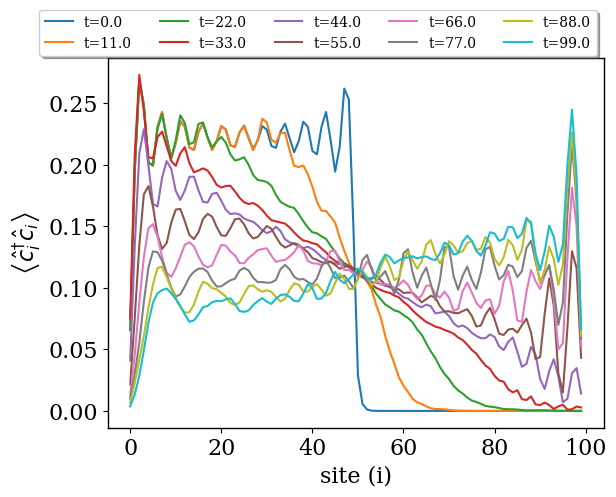

In [55]:
prequench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=1_L=100_OBC.txt').T
prequench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=1_L=100_OBC.txt')
postquench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=0_L=100_OBC.txt').T
postquench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=0_L=100_OBC.txt')
sites = np.linspace(0,99,100,dtype=int)

#############################################
### plot pre- and post-quench eigenstates ###
#############################################
# plt.plot(sites,np.abs(prequench_state[0])**2,color='black')
# plt.plot(sites,np.abs(postquench_state[0])**2,color='gray')

##########################################################
### occupations; time evolved, prequench to postquench ###
##########################################################
times = np.linspace(0,99,10)
for time in times:
    P = GaussianMat(11,prequench_state,postquench_state,postquench_energy,time)
    corr = NCorrMat(P)
    n = [corr[i][i] for i in sites]
    plt.plot(sites,n,label='t='+str(np.round(time,3)))
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.15),fancybox=True,shadow=True)


#################################
### make an animation for fun ###
#################################
# fig, ax = plt.subplots()
# artists = []
# times = np.linspace(0,2000,500)
# for time in times:
#     P = GaussianMat(11,prequench_state,postquench_state,postquench_energy,time)
#     corr = NCorrMat(P)
#     n = [corr[i][i] for i in sites]
#     container = ax.plot(sites,n,color='black')
#     artists.append(container)
# ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=40)
# ani.save(filename="quench_test.gif", writer="pillow")


### Quench: half-step, L=1000 PBC

In [ ]:
prequench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=1_L=1000.txt').T
prequench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=1_L=1000.txt')
postquench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=0_L=1000.txt').T
postquench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=0_L=1000.txt')
sites = np.linspace(0,999,1000,dtype=int)

#############################################
### plot pre- and post-quench eigenstates ###
#############################################
# plt.plot(sites,np.abs(prequench_state[0])**2,color='black')
# plt.plot(sites,np.abs(postquench_state[0])**2,color='gray')



#########################################################
### occupations; single time, prequench to postquench ###
#########################################################
time = 0
P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
corr = NCorrMat(P)
n = [corr[i][i] for i in sites]
plt.plot(sites,n,label='t='+str(np.round(time,1)),color='tab:red',linestyle='--')
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5)



##########################################################
### occupations; time evolved, prequench to postquench ###
##########################################################
times = np.linspace(0,10000,100)
for time in times:
    P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
    corr = NCorrMat(P)
    n = [corr[i][i] for i in sites]
    plt.plot(sites,n,color='black',alpha=time/max(times))
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.15),frameon=False,shadow=True)



#########################################################
### occupations; single time, postquench to prequench ###
#########################################################
# time = 100
# j=500
# P = GaussianMat(51,postquench_state,prequench_state,prequench_energy,time)
# corr = NCorrMat(P)
# n = [corr[i][i] for i in sites]
# plt.plot(sites,n,marker='.',label='t='+str(np.round(time,3)),color='black')
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5)



##########################################################
### occupations; time evolved, postquench to prequench ###
##########################################################
# times = np.linspace(0,1000,21)
# for time in times:
#     P = GaussianMat(51,postquench_state,prequench_state,prequench_energy,time)
#     corr = NCorrMat(P)
#     n = [corr[i][i] for i in sites]
#     plt.plot(sites,n,label='t='+str(np.round(time,3)))
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.3),frameon=False,shadow=True)



######################################################################
### i != j correlations; many times, prequench to postquench state ###
######################################################################
# j=500
# times = np.linspace(0,100,21,dtype=int)
# for time in times:
#     P = GaussianMat(251,prequench_state,postquench_state,postquench_energy,time)
#     corr = NCorrMat(P)
#     n = [corr[i][j] for i in sites]
#     plt.plot(sites,n,label='t='+str(np.round(time,3)))
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{j}\right\rangle$ $j=$' + str(j),fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.3),frameon=False,shadow=True)


### Quench: half-step, L=1000 OBC

In [ ]:
prequench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=1_L=1000_OBC.txt').T
prequench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=1_L=1000_OBC.txt')
postquench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=0_L=1000_OBC.txt').T
postquench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=0_L=1000_OBC.txt')
sites = np.linspace(0,999,1000,dtype=int)

#############################################
### plot pre- and post-quench eigenstates ###
#############################################
# plt.plot(sites,np.abs(prequench_state[0])**2,color='black')
# plt.plot(sites,np.abs(postquench_state[0])**2,color='gray')



#########################################################
### occupations; single time, prequench to postquench ###
#########################################################
# time = 0
# P = GaussianMat(11,postquench_state,postquench_state,postquench_energy,time)
# corr = NCorrMat(P)
# corr[j][j]
# n = [corr[j][j] for j in sites]
# plt.plot(sites,n,label='t='+str(np.round(time,3)),color='black')
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5)



##########################################################
### occupations; time evolved, prequench to postquench ###
##########################################################
times = np.linspace(0,10000,100)
for time in times:
    P = GaussianMat(51,prequench_state,postquench_state,postquench_energy,time)
    corr = NCorrMat(P)
    n = [corr[i][i] for i in sites]
    plt.plot(sites,n,color='black',alpha=time/max(times))
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.15),frameon=False)



####################################################################
### time evolved single site occupation; prequench to postquench ###
####################################################################
# times = np.linspace(0,4000,1001)
# nj = []
# j = 500
# for t in times:
#     P = GaussianMat(51,prequench_state,postquench_state,postquench_energy,t)
#     corr = NCorrMat(P)
#     nj.append(corr[j][j])
# plt.plot(times,nj,color='black',label='i='+str(j))
# plt.xlabel('t (a.u.)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(frameon=False)

### quench: trap, g=10, L=1000, PBC

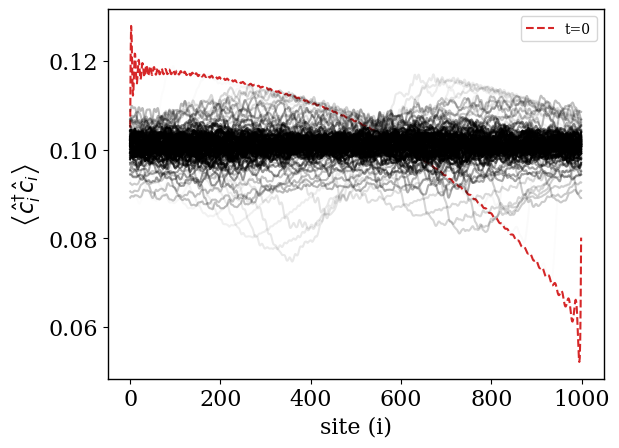

In [167]:
prequench_state = np.loadtxt('ODFF_trap_eigvec_t=1_v=0_g=10_L=1000.txt').T
prequench_energy = np.loadtxt('ODFF_trap_eigval_t=1_v=0_g=10_L=1000.txt')
postquench_state = np.loadtxt('ODFF_trap_eigvec_t=1_v=0_g=0_L=1000.txt').T
postquench_energy = np.loadtxt('ODFF_trap_eigval_t=1_v=0_g=0_L=1000.txt')
sites = np.linspace(0,len(prequench_state[0])-1,len(prequench_state[0]),dtype=int)

#############################################
### plot pre- and post-quench eigenstates ###
#############################################
# for i in range(11):
#     plt.plot(sites,np.abs(prequench_state[i])**2)
#     plt.plot(sites,np.abs(postquench_state[i])**2,linestyle='--')

#########################################################
### occupations; single time, prequench to postquench ###
#########################################################
time = 0
P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
corr = NCorrMat(P)
n = [corr[i][i] for i in sites]
plt.plot(sites,n,label='t='+str(np.round(time,1)),color='tab:red',linestyle='--')
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5)

##########################################################
### occupations; time evolved, prequench to postquench ###
##########################################################
times = np.linspace(0,10000,100)
for time in times:
    P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
    corr = NCorrMat(P)
    n = [corr[i][i] for i in sites]
    plt.plot(sites,n,color='black',alpha=time/max(times))
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
# plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.15),frameon=False,shadow=True)

#################################
### make an animation for fun ###
#################################
# fig, ax = plt.subplots()
# artists = []
# times = np.linspace(0,20000,600)
# for time in times:
#     P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
#     corr = NCorrMat(P)
#     n = [corr[i][i] for i in sites]
#     container = ax.plot(sites,n,color='black')
#     artists.append(container)
# ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=40)
# ani.save(filename="trap_quench_PBC.gif", writer="pillow")

### quench: trap, g=10, L=1000, OBC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


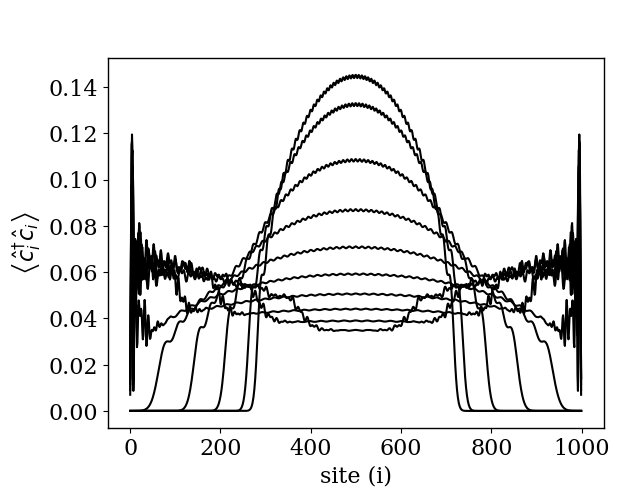

In [32]:
prequench_state = np.loadtxt('spectra/ODFF_trap_eigvec_t=1_v=0_g=1_L=1000_OBC.txt').T
prequench_energy = np.loadtxt('spectra/ODFF_trap_eigval_t=1_v=0_g=1_L=1000_OBC.txt')
postquench_state = np.loadtxt('spectra/ODFF_trap_eigvec_t=1_v=0_g=0_L=1000_OBC.txt').T
postquench_energy = np.loadtxt('spectra/ODFF_trap_eigval_t=1_v=0_g=0_L=1000_OBC.txt')
sites = np.linspace(0,len(prequench_state[0])-1,len(prequench_state[0]),dtype=int)

#############################################
### plot pre- and post-quench eigenstates ###
#############################################
# for i in range(11):
#     plt.plot(sites,np.abs(prequench_state[i])**2)
#     plt.plot(sites,np.abs(postquench_state[i])**2,linestyle='--')

#########################################################
### occupations; single time, prequench to postquench ###
#########################################################
# time = 100
# P = GaussianMat(51,prequench_state,postquench_state,postquench_energy,time)
# corr = NCorrMat(P)
# n = [corr[i][i] for i in sites]
# plt.plot(sites,n,label='t='+str(np.round(time,1)),color='tab:red',linestyle='--')
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,frameon=False)


##########################################################
### occupations; time evolved, prequench to postquench ###
##########################################################
times = np.linspace(0,1000,10)
for time in times:
    P = GaussianMat(51,prequench_state,postquench_state,postquench_energy,time)
    corr = NCorrMat(P)
    n = np.diag(corr)
    plt.plot(sites,n,color='black')
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.15),frameon=False,shadow=True)

##################################################################
### i != j correlations; time evolved, prequench to postquench ###
##################################################################
# j = 500
# times = np.linspace(0,4000,11)
# for time in times:
#     P = GaussianMat(51,prequench_state,postquench_state,postquench_energy,time)
#     corr = NCorrMat(P)
#     n = [corr[j][i] for i in sites]
#     plt.plot(sites,n,label='t='+str(np.round(time,3)))
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,loc='upper right',bbox_to_anchor=(1,1.2),frameon=False,shadow=True)

#################################
### make an animation for fun ###
#################################
# fig, ax = plt.subplots()
# artists = []
# times = np.linspace(0,20000,600)
# for time in times:
#     P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
#     corr = NCorrMat(P)
#     n = [corr[i][i] for i in sites]
#     container = ax.plot(sites,n,color='black')
#     artists.append(container)
# ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=40)
# ani.save(filename="trap_quench_OBC_V2.gif", writer="pillow")

####################################################################
### time evolved single site occupation; prequench to postquench ###
####################################################################
# times = np.linspace(0,20000,600)
# nj = []
# j = 500
# for t in times:
#     P = GaussianMat(51,prequench_state,postquench_state,postquench_energy,t)
#     corr = NCorrMat(P)
#     nj.append(corr[j][j])
# plt.plot(times,nj,color='black',label='i='+str(j))
# plt.xlabel('t (a.u.)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(frameon=False)


# Finite temperature -- equilibrium

### Free fermions on a lattice; L=100, OBC

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=0_L=100_OBC.txt')
eigenvectors = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=0_L=100_OBC.txt').T # .T yields a matrix of row vectors
planewaves = np.loadtxt('ODFF_eigvec_t=1_v=0.1_g=0_L=100.txt').T
planewaves_eng = np.loadtxt('ODFF_eigval_t=1_v=0.1_g=0_L=100.txt')
sites=np.linspace(0,99,100)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
nq = np.zeros(len(sites)) # vacuum state
Np = 21 # number of total particles, should be odd to avoid questions of degneracy
L=len(eigenvalues)
temps = [1000,10,1]
for i in range(Np): # np particle ground state
    nq[i] = 1
    
fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    n = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))
    N = np.round(np.sum(n),1)
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$; $N=$'+str(N))


ManyC = [NC(i,i,nq,eigenvectors) for i in range(len(sites))]
plt.plot(sites,ManyC,linestyle='--',color='black',label=r'$\beta \rightarrow \infty$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(ncols=2,frameon=False,fontsize=12)

###########################################################
### plot i!=j correlations as a function of temperature ###
###########################################################
j=0
L=len(eigenvalues)
nq = np.zeros(len(sites)) # vacuum state
Np = 21 # number of total particles, should be odd to avoid questions of degneracy
temps = [50,10,1]
for i in range(Np): # np particle ground state
    nq[i] = 1

fig = plt.figure()
fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     n = [NCorrFiniteT(i,j,L,T,eigenvectors,eigenvalues,chempot) for i in range(len(sites))]
#     n[j] = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))[j]
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    NCorr = NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot)
    n = NCorr[j]
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

ManyC = [NC(i,j,nq,eigenvectors) for i in range(len(sites))]
plt.plot(sites,ManyC,linestyle='--',color='black',label='$T=0$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(frameon=False,fontsize=12)


#############################################################
### plot nk occupation as a function of k and temperature ###
#############################################################
temps = [100,10,2]
linestyles = ['--','-.',':']
fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(100,71,T,eigenvectors,eigenvalues)
    k = np.linspace(-np.pi,np.pi,101)
    n = []
    for q in k:
        n.append(nk(q,100,T,eigenvectors,eigenvalues,chempot))
    print(np.sum(n[:-1])) # excludes other end of BZ
    plt.plot(k,n,label=r'$\beta=$'+str(T)+'$/t$')
    plt.plot(k,FermiDirac(T,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T)+'$/t$')
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)

### Free fermions on a lattice; L=100, PBC

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_eigval_t=1_v=0.1_g=0_L=100.txt')
eigenvectors = np.loadtxt('ODFF_eigvec_t=1_v=0.1_g=0_L=100.txt').T # .T yields a matrix of row vectors
sites=np.linspace(0,99,100)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
nq = np.zeros(len(sites)) # vacuum state
Np = 21 # number of total particles, should be odd to avoid questions of degneracy
L=len(eigenvalues)
temps = [1000,10,1]
for i in range(Np): # np particle ground state
    nq[i] = 1
    
fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    n = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))
    N = np.round(np.sum(n),1)
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$; $N=$'+str(N))


ManyC = [NC(i,i,nq,eigenvectors) for i in range(len(sites))]
plt.plot(sites,ManyC,linestyle='--',color='black',label=r'$\beta \rightarrow \infty$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(ncols=2,frameon=False,fontsize=12)
plt.ylim(0,0.25)

###########################################################
### plot i!=j correlations as a function of temperature ###
###########################################################
j=0
L=len(eigenvalues)
nq = np.zeros(len(sites)) # vacuum state
Np = 21 # number of total particles, should be odd to avoid questions of degneracy
temps = [50,10,1]
for i in range(Np): # np particle ground state
    nq[i] = 1

fig = plt.figure()
fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     n = [NCorrFiniteT(i,j,L,T,eigenvectors,eigenvalues,chempot) for i in range(len(sites))]
#     n[j] = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))[j]
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    NCorr = NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot)
    n = NCorr[j]
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

ManyC = [NC(i,j,nq,eigenvectors) for i in range(len(sites))]
plt.plot(sites,ManyC,linestyle='--',color='black',label='$T=0$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(frameon=False,fontsize=12)


#############################################################
### plot nk occupation as a function of k and temperature ###
#############################################################
temps = [100,10,2]
linestyles = ['--','-.',':']
fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(100,51,T,eigenvectors,eigenvalues)
    k = np.linspace(-np.pi,np.pi,101)
    n = []
    for q in k:
        n.append(nk(q,100,T,eigenvectors,eigenvalues,chempot))
    print(np.sum(n[:-1])) # excludes other end of BZ
    plt.plot(k,n,label=r'$\beta=$'+str(T)+'$/t$')
    plt.plot(k,FermiDirac(T,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T)+'$/t$')
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)

### Free fermions with trap; L=100, OBC

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_trap_eigval_t=1_v=0_g=10_L=100_OBC.txt')
eigenvectors = np.loadtxt('ODFF_trap_eigvec_t=1_v=0_g=10_L=100_OBC.txt').T # .T yields a matrix of row vectors
sites=np.linspace(0,99,100)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
nq = np.zeros(len(sites)) # vacuum state
Np = 11 # number of total particles, should be odd to avoid questions of degneracy
L=len(eigenvalues)
temps = [100,10,2]
for i in range(Np): # np particle ground state
    nq[i] = 1
    
fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    n = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))
    N = np.round(np.sum(n),1)
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$; $N=$'+str(N)+'$/t$')


ManyC = [NC(i,i,nq,eigenvectors) for i in range(len(sites))]
plt.plot(sites,ManyC,linestyle='--',color='black',label=r'$\beta \rightarrow \infty$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(ncols=2,frameon=False,fontsize=12)

###########################################################
### plot i!=j correlations as a function of temperature ###
###########################################################
j=0
L=len(eigenvalues)
nq = np.zeros(len(sites)) # vacuum state
Np = 11 # number of total particles, should be odd to avoid questions of degneracy
temps = [50,10,1]
for i in range(Np): # np particle ground state
    nq[i] = 1

fig = plt.figure()
fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     n = [NCorrFiniteT(i,j,L,T,eigenvectors,eigenvalues,chempot) for i in range(len(sites))]
#     n[j] = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))[j]
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    NCorr = NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot)
    n = NCorr[j]
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

ManyC = [NC(i,j,nq,eigenvectors) for i in range(len(sites))]
plt.plot(sites,ManyC,linestyle='--',color='black',label='$T=0$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(frameon=False,fontsize=12)


#############################################################
### plot nk occupation as a function of k and temperature ###
#############################################################
temps = [100,10,2]
linestyles = ['--','-.',':']

fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(100,11,T,eigenvectors,eigenvalues)
    k = np.linspace(-np.pi,np.pi,101)
    n = []
    for q in k:
        n.append(nk(q,100,T,eigenvectors,eigenvalues,chempot))
    print(np.sum(n[:-1])) # excludes other end of BZ
    plt.plot(k,n,label=r'$\beta=$'+str(T))
plt.plot(k,FermiDirac(1e3,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T))
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)

### Free fermions with trap; L=100, PBC

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_trap_eigval_t=1_v=0_g=1_L=100_PBC.txt')
eigenvectors = np.loadtxt('ODFF_trap_eigvec_t=1_v=0_g=1_L=100_PBC.txt').T # .T yields a matrix of row vectors
sites=np.linspace(0,99,100)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
nq = np.zeros(len(sites)) # vacuum state
Np = 21 # number of total particles, should be odd to avoid questions of degneracy
L=len(eigenvalues)
temps = [100,10,2]
for i in range(Np): # np particle ground state
    nq[i] = 1
    
fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    n = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))
    N = np.round(np.sum(n),1)
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$; $N=$'+str(N)+'$/t$')


ManyC = [NC(i,i,nq,eigenvectors) for i in range(len(sites))]
plt.plot(sites,ManyC,linestyle='--',color='black',label=r'$\beta \rightarrow \infty$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(ncols=2,frameon=False,fontsize=12)

###########################################################
### plot i!=j correlations as a function of temperature ###
###########################################################
j=50
L=len(eigenvalues)
nq = np.zeros(len(sites)) # vacuum state
Np = 21 # number of total particles, should be odd to avoid questions of degneracy
temps = [100,10,2]
for i in range(Np): # np particle ground state
    nq[i] = 1

fig = plt.figure()
fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     n = [NCorrFiniteT(i,j,L,T,eigenvectors,eigenvalues,chempot) for i in range(len(sites))]
#     n[j] = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))[j]
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    NCorr = NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot)
    n = NCorr[j]
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

ManyC = [NC(i,j,nq,eigenvectors) for i in range(len(sites))]
plt.plot(sites,ManyC,linestyle='--',color='black',label='$T=0$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(frameon=False,fontsize=12)


#############################################################
### plot nk occupation as a function of k and temperature ###
#############################################################
temps = [100,10,2]
linestyles = ['--','-.',':']

fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(100,51,T,eigenvectors,eigenvalues)
    k = np.linspace(-np.pi,np.pi,101)
    n = []
    for q in k:
        n.append(nk(q,100,T,eigenvectors,eigenvalues,chempot))
    print(np.sum(n[:-1])) # excludes other end of BZ
    plt.plot(k,n,label=r'$\beta=$'+str(T))
plt.plot(k,FermiDirac(1e3,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T))
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)

### Free fermions on a lattice; L=1000, OBC

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=0_L=1000_OBC.txt')
eigenvectors = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=0_L=1000_OBC.txt').T # .T yields a matrix of row vectors
sites=np.linspace(0,999,1000)

#########################
### plot eigenvectors ###
#########################
# for i in range(11):
#     plt.plot(sites,eigenvectors[i])
# plt.xlabel('Sites (i)',fontsize=16)
# plt.ylabel(r'$\left| \psi(x_i) \right|^2$',fontsize=16)
# plt.tick_params(labelsize=16)


##############################################################
### plot local number density as a function of temperature ###
##############################################################
nq = np.zeros(len(sites)) # vacuum state
Np = 51 # number of total particles, should be odd to avoid questions of degneracy
L=len(eigenvalues)
temps = [1000,10,2]
nq[0:Np] = 1 # ground state
    
fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    n = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))
    N = np.round(np.sum(n),1)
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

ManyC = NC2(nq,eigenvectors)
plt.plot(sites,np.diag(ManyC),linestyle='--',color='black',label=r'$\beta \rightarrow \infty$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(ncols=2,frameon=False,fontsize=12)


###########################################################
### plot i!=j correlations as a function of temperature ###
###########################################################
j=500
L=len(eigenvalues)
nq = np.zeros(len(sites)) # vacuum state
Np = 101 # number of total particles, should be odd to avoid questions of degneracy
temps = [100,10,1e-1]
nq[0:Np] = 1 # ground state

fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
    NCorr = NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot)
    n = [NCorr[j][i] for i in range(len(sites))]
    plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

ManyC = NC2(nq,eigenvectors)
plt.plot(sites,ManyC[j],linestyle='--',color='black',label=r'$\beta \rightarrow \infty$')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{j} \rangle$ $j=$'+str(j),fontsize=16)
plt.legend(frameon=False,fontsize=12)

#############################################################
### plot nk occupation as a function of k and temperature ###
#############################################################
# temps = [100,10,2]
# linestyles = ['--','-.',':']
# fig = plt.figure()
# fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(1000,501,T,eigenvectors,eigenvalues)
#     k = np.linspace(-np.pi,np.pi,101)
#     n = []
#     for q in k:
#         n.append(nk(q,1000,T,eigenvectors,eigenvalues,chempot))
#     print(np.sum(n))
#     plt.plot(k,n,label=r'$\beta=$'+str(T)+'$/t$')
#     plt.plot(k,FermiDirac(T,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T)+'$/t$')
# plt.xlabel('$ka$',fontsize=16)
# plt.ylabel('$n_k$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(frameon=False,fontsize=12)

### Trapped fermions, L = 1000; OBC

(100.9999957065814-5.0755114171984134e-17j)
(100.99999575494239-2.762497372307414e-17j)
(100.99999577456805+3.5902338502320774e-17j)


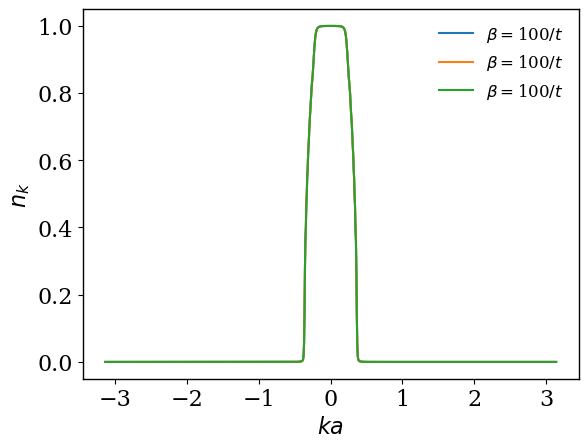

In [171]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_trap_eigval_t=1_v=0_g=1_L=1000_OBC.txt')
eigenvectors = np.loadtxt('ODFF_trap_eigvec_t=1_v=0_g=1_L=1000_OBC.txt').T # .T yields a matrix of row vectors
sites=np.linspace(0,999,1000)

#########################
### plot eigenvectors ###
#########################
# plt.plot(sites,np.abs(eigenvectors[11])**2)
# plt.xlabel('Sites (i)',fontsize=16)
# plt.ylabel(r'$\left| \psi(x_i) \right|^2$',fontsize=16)
# plt.tick_params(labelsize=16)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# L=len(eigenvalues)
# temps = [100,10,2]
# nq[0:Np] = 1
    
# fig = plt.figure()
# fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     n = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))
#     # N = np.round(np.sum(n),1)
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')


# # n = np.diag(NCorrFiniteTDiag(100,200,eigenvectors,eigenvalues,chempot))
# # plt.plot(sites,n,label='T='+str(200)+'$\hbar/t$')

# ManyC = NC2(nq,eigenvectors)
# plt.plot(sites,np.diag(ManyC),linestyle='--',color='black',label=r'$\beta \rightarrow \infty$')
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
# plt.legend(frameon=False,fontsize=12)

###########################################################
### plot i!=j correlations as a function of temperature ###
###########################################################
# j=500
# L=len(eigenvalues)
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# temps = [100,10,2]
# for i in range(Np): # np particle ground state
#     nq[i] = 1

# fig = plt.figure()
# fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     NCorr = NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot)
#     # n = [NCorr[j][i] for i in range(len(sites))]
#     n = NCorr[j]
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

# # ManyC = [NC(i,j,nq,eigenvectors) for i in range(len(sites))]
# # plt.plot(sites,ManyC,linestyle='--',color='black')
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{j} \rangle$ $j=$'+str(j),fontsize=16)
# plt.legend(frameon=False,fontsize=12)

#############################################################
### plot nk occupation as a function of k and temperature ###
#############################################################
# temps = [100]
# linestyles = ['--','-.',':']
# fig = plt.figure()
# fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(1000,101,T,eigenvectors,eigenvalues)
#     k = np.linspace(-np.pi,np.pi,1001)
#     NCorr = NCorrFiniteTDiag(len(sites),T,eigenvectors,eigenvalues,chempot)
#     n = list(map(lambda q: nk(q,1000,NCorr),k))
#     # for q in k:
#     #     n.append(nk(q,1000,NCorr))
#     print(np.sum(n))
#     plt.plot(k,n,label=r'$\beta=$'+str(T)+'$/t$')
#     # plt.plot(k,FermiDirac(T,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T))
# plt.xlabel('$ka$',fontsize=16)
# plt.ylabel('$n_k$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(frameon=False,fontsize=12)

############################################################
### plot nk as a function of k and time; temperature T=0 ###
############################################################
fig = plt.figure()
fig.tight_layout()
times = [1,1000,10000]
for time in times:
    P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
    NCorr = NCorrMat(P)
    n = list(map(lambda q: nk(q,1000,NCorr),k))
    # for q in k:
    #     n.append(nk(q,1000,NCorr))
    print(np.sum(n))
    plt.plot(k,n,label=r'$\beta=$'+str(T)+'$/t$')
    # plt.plot(k,FermiDirac(T,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T))
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)

### Free fermions with a half-step potential; L=1000, OBC

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=1_L=1000_OBC.txt')
eigenvectors = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=1_L=1000_OBC.txt').T # .T yields a matrix of row vectors
sites=np.linspace(0,999,1000)

#########################
### plot eigenvectors ###
#########################
# plt.plot(sites,np.abs(eigenvectors[11])**2)
# plt.xlabel('Sites (i)',fontsize=16)
# plt.ylabel(r'$\left| \psi(x_i) \right|^2$',fontsize=16)
# plt.tick_params(labelsize=16)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# L=len(eigenvalues)
# temps = [100,10,2]
# for i in range(Np): # np particle ground state
#     nq[i] = 1
    
# fig = plt.figure()
# fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     n = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))
#     # N = np.round(np.sum(n),1)
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')


# # n = np.diag(NCorrFiniteTDiag(100,200,eigenvectors,eigenvalues,chempot))
# # plt.plot(sites,n,label='T='+str(200)+'$\hbar/t$')

# # ManyC = [NC(i,i,nq,eigenvectors) for i in range(len(sites))]
# # plt.plot(sites,ManyC,linestyle='--',color='black',label=r'$\beta \rightarrow \infty$')
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
# plt.legend(frameon=False,fontsize=12)

###########################################################
### plot i!=j correlations as a function of temperature ###
###########################################################
# j=500
# L=len(eigenvalues)
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# temps = [100,10,2]
# for i in range(Np): # np particle ground state
#     nq[i] = 1

# fig = plt.figure()
# fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     NCorr = NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot)
#     # n = [NCorr[j][i] for i in range(len(sites))]
#     n = NCorr[j]
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

# # ManyC = [NC(i,j,nq,eigenvectors) for i in range(len(sites))]
# # plt.plot(sites,ManyC,linestyle='--',color='black')
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{j} \rangle$ $j=$'+str(j),fontsize=16)
# plt.legend(frameon=False,fontsize=12)

#############################################################
### plot nk occupation as a function of k and temperature ###
#############################################################
temps = [100]
linestyles = ['--','-.',':']
fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(1000,101,T,eigenvectors,eigenvalues)
    k = np.linspace(-np.pi,np.pi,101)
    n = []
    for q in k:
        n.append(nk(q,1000,T,eigenvectors,eigenvalues,chempot))
    print(np.sum(n))
    plt.plot(k,n,label=r'$\beta=$'+str(T)+'$/t$')
    plt.plot(k,FermiDirac(T,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T))
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)

### Free fermions with a random potential; L=1000, PBC

In [ ]:
############
### load ###
############
eigenvalues = np.loadtxt('ODFF_random_eigval_t=1_v=0_g=0.5_L=1000_OBC.txt')
eigenvectors = np.loadtxt('ODFF_random_eigvec_t=1_v=0_g=0.5_L=1000_OBC.txt').T # .T yields a matrix of row vectors
sites=np.linspace(0,999,1000)

#########################
### plot eigenvectors ###
#########################
# plt.plot(sites,np.abs(eigenvectors[11])**2)
# plt.xlabel('Sites (i)',fontsize=16)
# plt.ylabel(r'$\left| \psi(x_i) \right|^2$',fontsize=16)
# plt.tick_params(labelsize=16)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# L=len(eigenvalues)
# temps = [100,10,2]
# for i in range(Np): # np particle ground state
#     nq[i] = 1
    
# fig = plt.figure()
# fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     n = np.diag(NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot))
#     N = np.round(np.sum(n),1)
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')


# # n = np.diag(NCorrFiniteTDiag(100,200,eigenvectors,eigenvalues,chempot))
# # plt.plot(sites,n,label='T='+str(200)+'$\hbar/t$')

# # ManyC = [NC(i,i,nq,eigenvectors) for i in range(len(sites))]
# # plt.plot(sites,ManyC,linestyle='--',color='black',label=r'$\beta \rightarrow \infty$')
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
# plt.legend(ncols=3,frameon=False,fontsize=12)

###########################################################
### plot i!=j correlations as a function of temperature ###
###########################################################
# j=500
# L=len(eigenvalues)
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# temps = [100,10,2]
# for i in range(Np): # np particle ground state
#     nq[i] = 1

# fig = plt.figure()
# fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,eigenvectors,eigenvalues)
#     NCorr = NCorrFiniteTDiag(L,T,eigenvectors,eigenvalues,chempot)
#     # n = [NCorr[j][i] for i in range(len(sites))]
#     n = NCorr[j]
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$')

# # ManyC = [NC(i,j,nq,eigenvectors) for i in range(len(sites))]
# # plt.plot(sites,ManyC,linestyle='--',color='black')
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{j} \rangle$ $j=$'+str(j),fontsize=16)
# plt.legend(frameon=False,fontsize=12)

#############################################################
### plot nk occupation as a function of k and temperature ###
#############################################################
temps = [100,10,1]
linestyles = ['--','-.',':']
fig = plt.figure()
fig.tight_layout()
for T in temps:
    chempot = GetChemicalPotential(1000,101,T,eigenvectors,eigenvalues)
    k = np.linspace(-np.pi,np.pi,101)
    n = []
    for q in k:
        n.append(nk(q,1000,T,eigenvectors,eigenvalues,chempot))
    print(np.sum(n))
    plt.plot(k,n,label=r'$\beta=$'+str(T)+'$/t$')
    # plt.plot(k,FermiDirac(T,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T))
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)

# Finite temperature -- non-equilibrium

### Random quench; L=1000; OBC

In [ ]:
############
### load ###
############
prequench_state = np.loadtxt('ODFF_random_eigvec_t=1_v=0_g=0_L=1000_OBC.txt').T
prequench_energy = np.loadtxt('ODFF_random_eigval_t=1_v=0_g=0_L=1000_OBC.txt')
postquench_state = np.loadtxt('ODFF_random_eigvec_t=1_v=0_g=0.5_L=1000_OBC.txt').T 
postquench_energy = np.loadtxt('ODFF_random_eigval_t=1_v=0_g=0.5_L=1000_OBC.txt')
sites = np.linspace(0,len(prequench_state[0])-1,len(prequench_state[0]),dtype=int)

############################
### local number denisty ###
############################
nq = np.zeros(len(sites)) # vacuum state
Np = 101 # number of total particles, should be odd to avoid questions of degneracy
Length = len(prequench_energy)
nq[0:Np] = 1
temp = 2
time = 100
tmax = 2000
timesteps = 25
mu = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)

densitymat = lambda time: pij(time,temp,mu,Length,prequench_state,postquench_state,prequench_energy,postquench_energy)
test = list(map(densitymat,range(0,tmax,timesteps)))

fig = plt.figure()
fig.tight_layout()
for i in range(0,int(tmax/timesteps)):
    plt.plot(sites,np.diag(test[i]),color='black',alpha=(i+1)*timesteps/tmax)
plt.plot(sites,np.diag(densitymat(0)),color='tab:red',linestyle='--')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
# plt.legend(frameon=False,fontsize=12)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# L=len(eigenvalues)
# temps = [100,10,2]
# nq[0:Np] = 1
    
# # fig = plt.figure()
# # fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,prequench_state,prequench_energy)
#     n = np.diag(NCorrFiniteTDiag(L,T,prequench_state,prequench_energy,chempot))
#     # N = np.round(np.sum(n),1)
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$',linestyle='--')

#########################################################
### occupations; single time, prequench to postquench ###
#########################################################
# P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
# corr = NCorrMat(P)
# n = [corr[i][i] for i in sites]
# plt.plot(sites,n,label='t='+str(np.round(time,1)),color='tab:red',linestyle='--')
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5)
# plt.xlim(0,100)

### Half step quench; L=100; OBC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


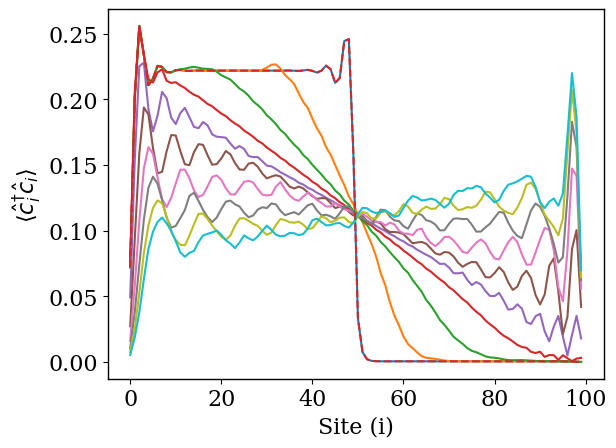

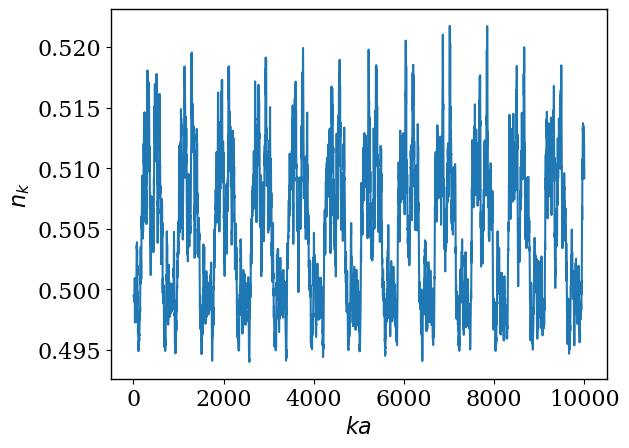

In [82]:
############
### load ###
############
prequench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=1_L=100_OBC.txt').T
prequench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=1_L=100_OBC.txt')
postquench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=0_L=100_OBC.txt').T
postquench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=0_L=100_OBC.txt')
sites = np.linspace(0,len(prequench_state[0])-1,len(prequench_state[0]),dtype=int)

############################
### local number denisty ###
############################
nq = np.zeros(len(sites)) # vacuum state
Np = 11 # number of total particles, should be odd to avoid questions of degneracy
Length = len(prequench_energy)
nq[0:Np] = 1
temp = 10
time = 100
tmax = 100
timesteps = 10
mu = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)

densitymat = lambda time: pij(time,temp,mu,Length,prequench_state,postquench_state,prequench_energy,postquench_energy)
test = list(map(densitymat,range(0,tmax,timesteps)))

fig = plt.figure()
fig.tight_layout()
for i in range(0,int(tmax/timesteps)):
    plt.plot(sites,np.diag(test[i]))
plt.plot(sites,np.diag(densitymat(0)),color='tab:red',linestyle='--')
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
# plt.legend(frameon=False,fontsize=12)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# L=len(eigenvalues)
# temps = [100,10,2]
# nq[0:Np] = 1
    
# # fig = plt.figure()
# # fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,prequench_state,prequench_energy)
#     n = np.diag(NCorrFiniteTDiag(L,T,prequench_state,prequench_energy,chempot))
#     # N = np.round(np.sum(n),1)
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$',linestyle='--')

#########################################################
### occupations; single time, prequench to postquench ###
#########################################################
# P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
# corr = NCorrMat(P)
# n = [corr[i][i] for i in sites]
# plt.plot(sites,n,label='t='+str(np.round(time,1)),color='tab:red',linestyle='--')
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5)
# plt.xlim(0,100)

#######################################
### momentum distribution functions ###
#######################################
fig = plt.figure()
fig.tight_layout()
temp=10
time = 50000
Np=11
chempot = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)
k = np.linspace(-np.pi,np.pi,101)
# n = []
# for q in k:
#     n.append(nkt(q,Length,temp,time,prequench_state,prequench_energy,postquench_state,postquench_energy,chempot))
# plt.plot(k,n,label=r'$t=$'+str(time)+'$\hbar/J$',color='tab:red')
# for t in range(0,100000,10000):
#     n = []
#     for q in k:
#         n.append(nkt(q,Length,temp,t,prequench_state,prequench_energy,postquench_state,postquench_energy,chempot))
#     plt.plot(k,n,label=r'$t=$'+str(t)+'$\hbar/J$')
n=[]
for t in range(0,10000,1):
    n.append(nkt(0,Length,temp,t,prequench_state,prequench_energy,postquench_state,postquench_energy,chempot))
plt.plot(np.linspace(0,10000,10000),n)
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)
# plt.xlim(0,np.pi)


#################################
### make an animation for fun ###
#################################
# fig, ax = plt.subplots()
# artists = []
# k = np.linspace(-np.pi,np.pi,101)
# times = np.linspace(0,4000,500)
# for time in times:
#     n = []
#     for q in k:
#         n.append(nkt(q,Length,temp,time,prequench_state,prequench_energy,postquench_state,postquench_energy,chempot))
#     container = ax.plot(k,n,color='black')
#     artists.append(container)
# ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=40)
# ani.save(filename="half_step_MDF.gif", writer="pillow")


### Half-step quench; L=1000; OBC

In [ ]:
############
### load ###
############
prequench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=1_L=1000_OBC.txt').T
prequench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=1_L=1000_OBC.txt')
postquench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=0_L=1000_OBC.txt').T
postquench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=0_L=1000_OBC.txt')
sites = np.linspace(0,999,1000,dtype=int)
Length = len(prequench_energy)

############################
### local number denisty ###
############################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# nq[0:Np] = 1
# temp = 2
# time = 100
# tmax = 4000
# timesteps = 50
# mu = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)

# densitymat = lambda time: pij(time,temp,mu,Length,prequench_state,postquench_state,prequench_energy,postquench_energy)
# test = list(map(densitymat,range(0,tmax,timesteps)))

# fig = plt.figure()
# fig.tight_layout()
# for i in range(0,int(tmax/timesteps)):
#     plt.plot(sites,np.diag(test[i]),color='black',alpha=(i+1)*timesteps/tmax)
# plt.plot(sites,np.diag(densitymat(0)),color='tab:red',linestyle='--',label=r'$\beta=$'+str(temp))
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
# plt.legend(frameon=False,fontsize=16,loc='upper right')

##############################################################
### plot local number density as a function of temperature ###
##############################################################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# L=len(eigenvalues)
# temps = [100,10,2]
# nq[0:Np] = 1
    
# # fig = plt.figure()
# # fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,prequench_state,prequench_energy)
#     n = np.diag(NCorrFiniteTDiag(L,T,prequench_state,prequench_energy,chempot))
#     # N = np.round(np.sum(n),1)
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$',linestyle='--')

#########################################################
### occupations; single time, prequench to postquench ###
#########################################################
# P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
# corr = NCorrMat(P)
# n = [corr[i][i] for i in sites]
# plt.plot(sites,n,label='t='+str(np.round(time,1)),color='tab:red',linestyle='--')
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5)
# plt.xlim(0,100)


######################################
### momentum distribution function ###
######################################
# temps = [100,10,1]
# linestyles = ['--','-.',':']
# for T in temps:
#     chempot = GetChemicalPotential(1000,101,T,eigenvectors,eigenvalues)
#     k = np.linspace(-np.pi,np.pi,101)
#     n = []
#     for q in k:
#         n.append(nk(q,1000,T,eigenvectors,eigenvalues,chempot))
#     print(np.sum(n))
#     plt.plot(k,n,label=r'$\beta=$'+str(T)+'$/t$')
#     plt.plot(k,FermiDirac(T,chempot,1,0.1,k),color='black',linestyle=linestyles[temps.index(T)],label=r'FD $\beta=$'+str(T))
fig = plt.figure()
fig.tight_layout()
temp=100
time=0
Np=101
chempot = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)
k = np.linspace(-np.pi,np.pi,51)
n = []
for q in k:
    n.append(nkt(q,Length,temp,time,prequench_state,prequench_energy,postquench_state,postquench_energy,chempot))
plt.plot(k,n,label=r'$\beta=$'+str(temp)+'$/t$')
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)

### Trap quench; L=100; OBC

C:\Users\jeffc\AppData\Local\Temp\ipykernel_17416\592703107.py:68: RuntimeWarning: overflow encountered in exp
  D = np.linalg.inv(I + np.diag(np.exp(-beta*(E-mu))))


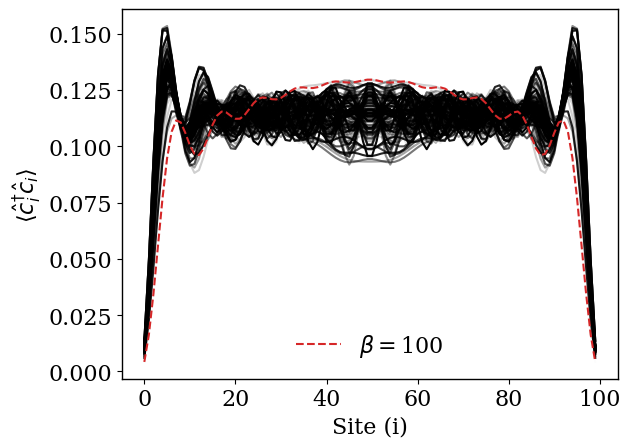

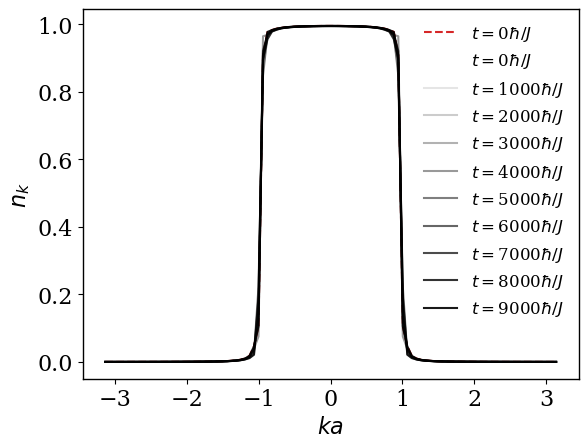

In [212]:
############
### load ###
############
prequench_energy = np.loadtxt('ODFF_trap_eigval_t=1_v=0_g=10_L=100_OBC.txt')
prequench_state = np.loadtxt('ODFF_trap_eigvec_t=1_v=0_g=10_L=100_OBC.txt').T # .T yields a matrix of row vectors
postquench_state = np.loadtxt('ODFF_shift_eigvec_t=1_v=0.1_g=0_L=100_OBC.txt').T
postquench_energy = np.loadtxt('ODFF_shift_eigval_t=1_v=0.1_g=0_L=100_OBC.txt')
sites=np.linspace(0,99,100)
Length = len(sites)

############################
### local number denisty ###
############################
nq = np.zeros(len(sites)) # vacuum state
Np = 11 # number of total particles, should be odd to avoid questions of degneracy
Length = len(prequench_energy)
nq[0:Np] = 1
temp = 100
time = 100
tmax = 10000
timesteps = 100
mu = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)

densitymat = lambda time: pij(time,temp,mu,Length,prequench_state,postquench_state,prequench_energy,postquench_energy)
test = list(map(densitymat,range(0,tmax,timesteps)))

fig = plt.figure()
fig.tight_layout()
for i in range(0,int(tmax/timesteps)):
    plt.plot(sites,np.diag(test[i]),color='black',alpha=(i+1)*timesteps/tmax)
plt.plot(sites,np.diag(densitymat(0)),color='tab:red',linestyle='--',label=r'$\beta=$'+str(temp))
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(frameon=False,fontsize=16)

############################
### two-point correlator ###
############################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# Length = len(prequench_energy)
# j = 500
# nq[0:Np] = 1
# temp = 2
# time = 100
# tmax = 4000
# timesteps = 500
# mu = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)

# densitymat = lambda time: pij(time,temp,mu,Length,prequench_state,postquench_state,prequench_energy,postquench_energy)
# # test = list(map(densitymat,range(0,tmax,timesteps)))

# fig = plt.figure()
# fig.tight_layout()
# # for i in range(0,int(tmax/timesteps)):
# #     plt.plot(sites,test[i][j],color='black',alpha=(i+1)*timesteps/tmax)
# plt.plot(sites,densitymat(50000)[j],color='tab:red',label=r'$\beta=$'+str(temp))
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{j} \rangle$',fontsize=16)
# plt.legend(frameon=False,fontsize=16)


#########################################################
### occupations; single time, prequench to postquench ###
#########################################################
# P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
# corr = NCorrMat(P)
# n = [corr[i][i] for i in sites]
# plt.plot(sites,n,label='t='+str(np.round(time,1)),color='tab:red',linestyle='--')
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5)
# plt.xlim(0,100)

#######################################
### momentum distribution functions ###
#######################################
fig = plt.figure()
fig.tight_layout()
temp = 1000
time = 500
Np=31
chempot = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)
k = np.linspace(-np.pi,np.pi,101)
NCorr = pij(t,temp,chempot,len(sites),prequench_state,postquench_state,prequench_energy,postquench_energy)
n = list(map(lambda q: nkt(q,Length,NCorr),k))
plt.plot(k,n,label=r'$t=$'+str(0)+'$\hbar/J$',color='tab:red',linestyle='--')
# plt.plot(k,n,label=r'$t=$'+str(time)+'$\hbar/J$',color='black')
for t in range(0,10000,1000):
    NCorr = pij(t,temp,chempot,len(sites),prequench_state,postquench_state,prequench_energy,postquench_energy)
    n = list(map(lambda q: nkt(q,Length,NCorr),k))
    plt.plot(k,n,label=r'$t=$'+str(t)+'$\hbar/J$',color='black',alpha=t/10000)
plt.xlabel('$ka$',fontsize=16)
plt.ylabel('$n_k$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(frameon=False,fontsize=12)
# plt.xlim(0,np.pi)

#################################
### make an animation for fun ###
#################################
# fig, ax = plt.subplots()
# artists = []
# k = np.linspace(-np.pi,np.pi,101)
# times = np.linspace(0,500,500)
# temp=10
# Np=31
# # chempot = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)
# for time in times:
#     P = GaussianMat(Np,prequench_state,postquench_state,postquench_energy,time)
#     NCorr = NCorrMat(P)
#     # NCorr = pij(time,temp,chempot,len(sites),prequench_state,postquench_state,prequench_energy,postquench_energy)
#     n = list(map(lambda q: nkt(q,Length,NCorr),k))
#     container = ax.plot(k,n,color='black')
#     artists.append(container)
# ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=40)
# ani.save(filename="trap_MDF_T=inf_t=500.gif", writer="pillow")

### Trap quench; L=1000; OBC

c:\Users\jeffc\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\jeffc\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


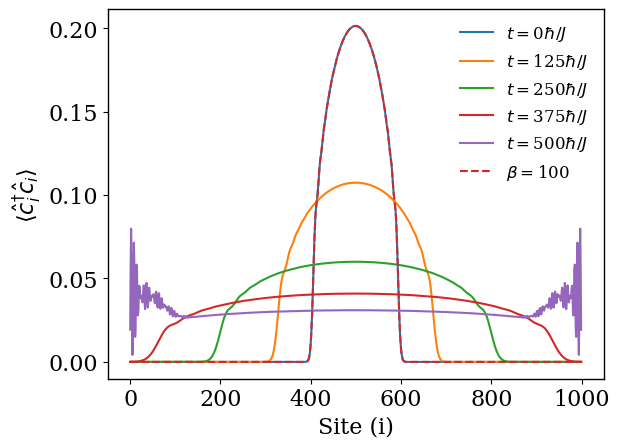

In [90]:
############
### load ###
############
prequench_state = np.loadtxt('spectra/ODFF_trap_eigvec_t=1_v=0_g=10_L=1000_OBC.txt').T
prequench_energy = np.loadtxt('spectra/ODFF_trap_eigval_t=1_v=0_g=10_L=1000_OBC.txt')
postquench_state = np.loadtxt('spectra/ODFF_trap_eigvec_t=1_v=0_g=0_L=1000_OBC.txt').T
postquench_energy = np.loadtxt('spectra/ODFF_trap_eigval_t=1_v=0_g=0_L=1000_OBC.txt')
sites = np.linspace(0,len(prequench_state[0])-1,len(prequench_state[0]),dtype=int)
Length = len(prequench_energy)

############################
### local number denisty ###
# ############################
nq = np.zeros(len(sites)) # vacuum state
Np = 31 # number of total particles, should be odd to avoid questions of degneracy
Length = len(prequench_energy)
nq[0:Np] = 1
temp = 100
time = 100
tmax = 500
timesteps = 125
mu = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)

densitymat = lambda time: pij(time,temp,mu,Length,prequench_state,postquench_state,prequench_energy,postquench_energy)
test = list(map(densitymat,range(0,tmax+1,timesteps)))

fig = plt.figure()
fig.tight_layout()
for i in range(0,int(tmax/timesteps)+1):
    plt.plot(sites,np.diag(test[i]),label=r'$t=$'+str(range(0,tmax+1,timesteps)[i])+r'$\hbar/J$')
plt.plot(sites,np.diag(densitymat(0)),color='tab:red',linestyle='--',label=r'$\beta=$'+str(temp))
plt.tick_params(labelsize=16)
plt.xlabel('Site (i)',fontsize=16)
plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{i} \rangle$',fontsize=16)
plt.legend(frameon=False,fontsize=12)

############################
### two-point correlator ###
############################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 101 # number of total particles, should be odd to avoid questions of degneracy
# Length = len(prequench_energy)
# j = 500
# nq[0:Np] = 1
# temp = 2
# time = 100
# tmax = 4000
# timesteps = 500
# mu = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)

# densitymat = lambda time: pij(time,temp,mu,Length,prequench_state,postquench_state,prequench_energy,postquench_energy)
# # test = list(map(densitymat,range(0,tmax,timesteps)))

# fig = plt.figure()
# fig.tight_layout()
# # for i in range(0,int(tmax/timesteps)):
# #     plt.plot(sites,test[i][j],color='black',alpha=(i+1)*timesteps/tmax)
# plt.plot(sites,densitymat(50000)[j],color='tab:red',label=r'$\beta=$'+str(temp))
# plt.tick_params(labelsize=16)
# plt.xlabel('Site (i)',fontsize=16)
# plt.ylabel(r'$\langle \hat{c}_{i}^{\dagger}\hat{c}_{j} \rangle$',fontsize=16)
# plt.legend(frameon=False,fontsize=16)

##############################################################
### plot local number density as a function of temperature ###
##############################################################
# nq = np.zeros(len(sites)) # vacuum state
# Np = 31 # number of total particles, should be odd to avoid questions of degneracy
# L=len(eigenvalues)
# temps = [1000,10,2]
# nq[0:Np] = 1
    
# # fig = plt.figure()
# # fig.tight_layout()
# for T in temps:
#     chempot = GetChemicalPotential(L,Np,T,prequench_state,prequench_energy)
#     n = np.diag(NCorrFiniteTDiag(L,T,prequench_state,prequench_energy,chempot))
#     # N = np.round(np.sum(n),1)
#     plt.plot(sites,n,label=r'$\beta$='+str(T)+'$/t$',linestyle='--')

#########################################################
### occupations; single time, prequench to postquench ###
#########################################################
# P = GaussianMat(101,prequench_state,postquench_state,postquench_energy,time)
# corr = NCorrMat(P)
# n = [corr[i][i] for i in sites]
# plt.plot(sites,n,label='t='+str(np.round(time,1)),color='tab:red',linestyle='--')
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5)
# plt.xlim(0,100)

#######################################
### momentum distribution functions ###
#######################################
# fig = plt.figure()
# fig.tight_layout()
# temp = 100
# times = [0,250,1000]
# Np = 31
# chempot = GetChemicalPotential(Length,Np,temp,prequench_state,prequench_energy)
# k = np.linspace(-np.pi,np.pi,101)[:-1]
# linestyle = ['-','--','-.']

# for t in times:
#     NCorr = pij(t,temp,chempot,len(sites),prequench_state,postquench_state,prequench_energy,postquench_energy)
#     mdf = lambda k: nkt(k,Length,NCorr)
#     n = list(map(mdf,k))
#     plt.plot(k,n,label=r'$t=$'+str(t)+'$\hbar/J$',linestyle=linestyle[times.index(t)])
# plt.xlabel('$ka$',fontsize=16)
# plt.ylabel('$n_k$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(frameon=False,fontsize=12)

In [88]:
len(test)
int(tmax/timesteps)

4

### Free expansion after a trap: MDF

Text(0.5, 1.0, '$\\text{Free (OBC)}\\ |\\ N=31\\ |\\ t_{\\text{pulse}}=0.1\\hbar/J\\ |\\ U_{\\text{pulse}}=20J\\ |\\ q=\\pi/4$')

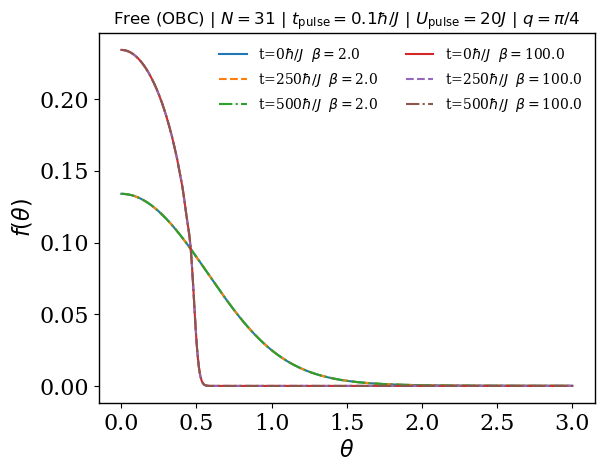

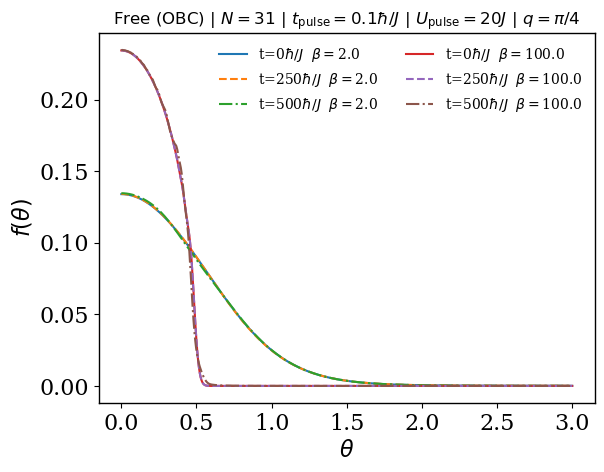

In [77]:
# plt.figure()
# plt.tight_layout()
# linestyles = ['-','--','-.',':','-.',':']
# for t in range(0,501,125):
#     n = np.fromfile('FreeExpansionFiniteT/n_trap_L=1000_N=31_t='+str(float(t))+'.bin')
#     plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+'$\hbar/J$',linestyle=linestyles[t])
# plt.xlabel('ka',fontsize = 16)
# plt.ylabel(r'$f(\theta)$',fontsize = 16)
# plt.legend(ncols=2,frameon=False)
# plt.tick_params(labelsize=16)
# plt.title(r'$\text{Trap (PBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

plt.figure()
plt.tight_layout()
temps = [2.0,100.0]
linestyles = ['-','--','-.','-','--','-.']
for b in temps:
    for t in range(0,501,250):
        n = np.fromfile('FreeExpansionFiniteT/n_trap_L=1000_N=31_t='+str(float(t))+'T='+str(b)+'.bin')
        plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+r'$\hbar/J$  $\beta=$'+str(b),linestyle=linestyles[range(0,501,250).index(t)])
plt.xlabel(r'$\theta$',fontsize = 16)
plt.ylabel(r'$f(\theta)$',fontsize = 16)
plt.legend(ncols=2,frameon=False)
plt.tick_params(labelsize=16)
plt.title(r'$\text{Free (OBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

plt.figure()
plt.tight_layout()
temps = [2.0,100.0]
linestyles = ['-','--','-.','-','--','-.','-','--','-.','-','--','-.']
for b in temps:
    for t in range(0,501,250):
        n = np.fromfile('FreeExpansionFiniteT/n_trap_OBC_L=1000_N=31_t='+str(float(t))+'T='+str(b)+'.bin')
        plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+r'$\hbar/J$  $\beta=$'+str(b),linestyle=linestyles[range(0,501,250).index(t)])
plt.xlabel(r'$\theta$',fontsize = 16)
plt.ylabel(r'$f(\theta)$',fontsize = 16)
plt.legend(ncols=2,frameon=False)
plt.tick_params(labelsize=16)
plt.title(r'$\text{Free (OBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

In [70]:
range(0,501,250).index(250)

1

# Bragg Scattering Pulse

0.04774212837219238


c:\Users\jeffc\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\jeffc\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


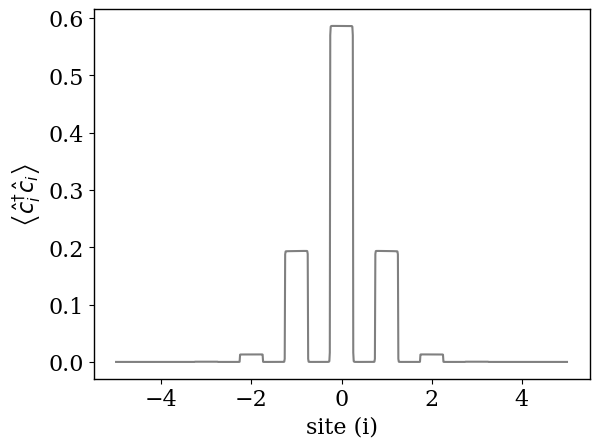

In [27]:
############
### load ###
############
trap_state = np.loadtxt('Bragg_quench/trap_eigvec_t=1_g=2_L=1000_PBC.txt').T
trap_energy = np.loadtxt('Bragg_quench/trap_eigval_t=1_g=2_L=1000_PBC.txt')
bragg_state = np.loadtxt('Bragg_quench/bragg_eigvec_t=1_L=1000_q=pi10_PBC.txt').T
bragg_energy = np.loadtxt('Bragg_quench/bragg_eigval_t=1_L=1000_q=pi10_PBC.txt')
free_state = np.loadtxt('Bragg_quench/free_eigvec_t=1_L=1000_PBC.txt').T
free_energy = np.loadtxt('Bragg_quench/free_eigval_t=1_L=1000_PBC.txt')
sites = np.linspace(0,len(free_state[0])-1,len(free_state[0]),dtype=int)
Length = len(free_energy)

###################################
### number density during pulse ###
###################################
# time = 0.1
# P = GaussianMat(101,free_state,bragg_state,bragg_energy,time)
# corr = NCorrMat(P)
# n = np.diag(corr)
# plt.plot(sites,n,label='t='+str(np.round(time,1)),color='tab:red')
# plt.xlabel('site (i)',fontsize=16)
# plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,frameon=False)
# # plt.xlim(400,500)

###########
### MDF ###
###########
start_time = time.time()
# for t in range(0,1,10):
t = 0.4
P = GaussianMat(51,free_state,bragg_state,bragg_energy,t)
corr = NCorrMat(P)
end_time = time.time()
print(end_time-start_time)
k = np.linspace(-np.pi,np.pi,1001)
n = list(map(lambda q: nkt(q,Length,corr),k))
plt.plot(k/(np.pi/5),n,color='gray')
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,frameon=False)

### Zero T

Text(0.5, 1.0, '$\\text{Free (OBC)}\\ |\\ N=31\\ |\\ t_{\\text{pulse}}=0.1\\hbar/J\\ |\\ U_{\\text{pulse}}=20J\\ |\\ q=\\pi/4$')

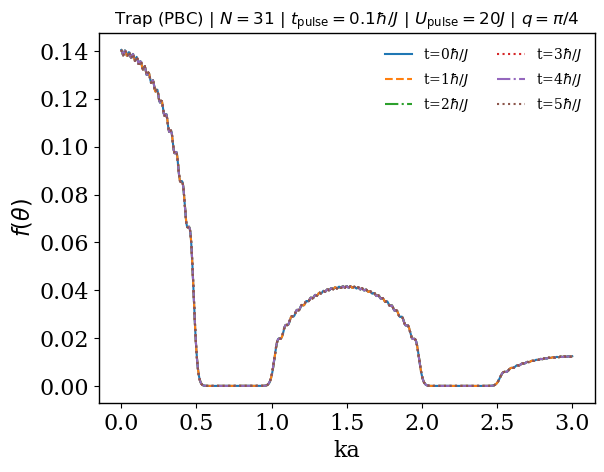

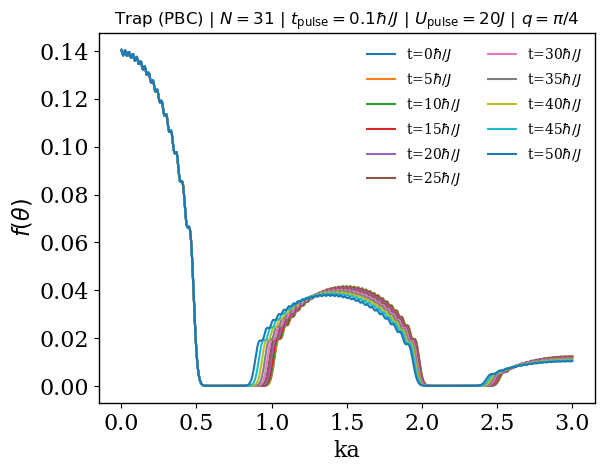

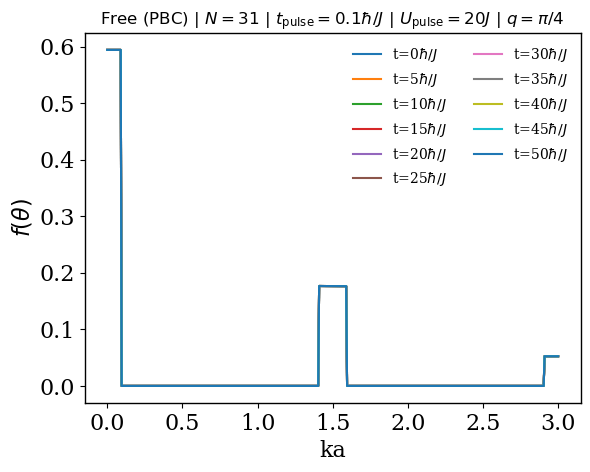

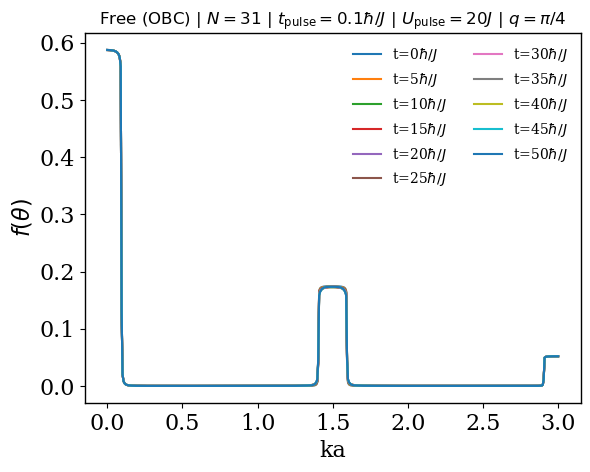

In [6]:
###############################
### Loading data from Julia ###
###############################

#########################
### trap; short times ###
#########################
plt.figure()
plt.tight_layout()
linestyles = ['-','--','-.',':','-.',':']
for t in range(0,6):
    n = np.fromfile('Bragg_quench/n_trap_L=1000_N=31_t='+str(float(t))+'.bin')
    plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+'$\hbar/J$',linestyle=linestyles[t])
plt.xlabel('ka',fontsize = 16)
plt.ylabel(r'$f(\theta)$',fontsize = 16)
plt.legend(ncols=2,frameon=False)
plt.tick_params(labelsize=16)
plt.title(r'$\text{Trap (PBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

########################
### trap; long times ###
########################
plt.figure()
plt.tight_layout()
for t in range(0,51,5):
    n = np.fromfile('Bragg_quench/n_trap_L=1000_N=31_t='+str(float(t))+'.bin')
    plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+'$\hbar/J$')
plt.xlabel('ka',fontsize = 16)
plt.ylabel(r'$f(\theta)$',fontsize = 16)
plt.legend(ncols=2,frameon=False)
plt.tick_params(labelsize=16)
plt.title(r'$\text{Trap (PBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

#############################
### free; long times; PBC ###
#############################
plt.figure()
plt.tight_layout()
for t in range(0,51,5):
    n = np.fromfile('Bragg_quench/n_free_L=1000_N=31_t='+str(float(t))+'.bin')
    plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+'$\hbar/J$')
plt.xlabel('ka',fontsize = 16)
plt.ylabel(r'$f(\theta)$',fontsize = 16)
plt.legend(ncols=2,frameon=False)
plt.tick_params(labelsize=16)
plt.title(r'$\text{Free (PBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

#############################
### free; long times; PBC ###
#############################
plt.figure()
plt.tight_layout()
for t in range(0,51,5):
    n = np.fromfile('Bragg_quench/n_free_OBC_L=1000_N=31_t='+str(float(t))+'.bin')
    plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+'$\hbar/J$')
plt.xlabel('ka',fontsize = 16)
plt.ylabel(r'$f(\theta)$',fontsize = 16)
plt.legend(ncols=2,frameon=False)
plt.tick_params(labelsize=16)
plt.title(r'$\text{Free (OBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

### Finite T

Text(0.5, 1.0, '$\\text{Free (PBC)}\\ |\\ N=31\\ |\\ t_{\\text{pulse}}=0.1\\hbar/J\\ |\\ U_{\\text{pulse}}=20J\\ |\\ q=\\pi/4$')

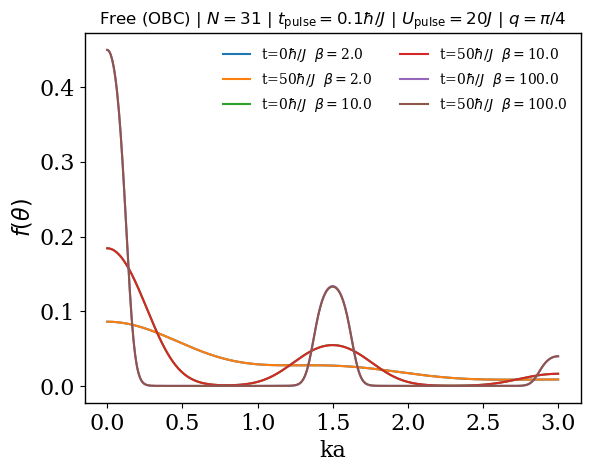

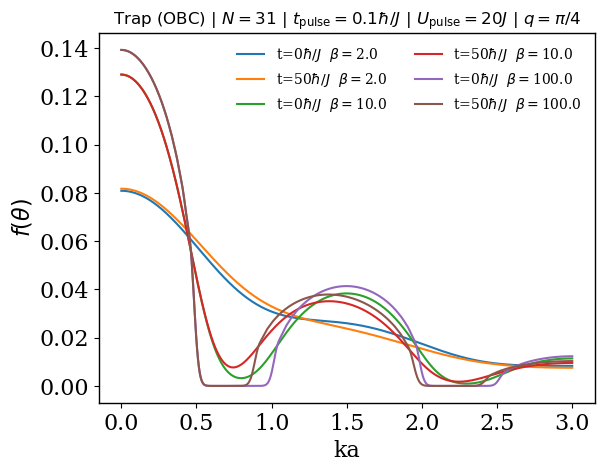

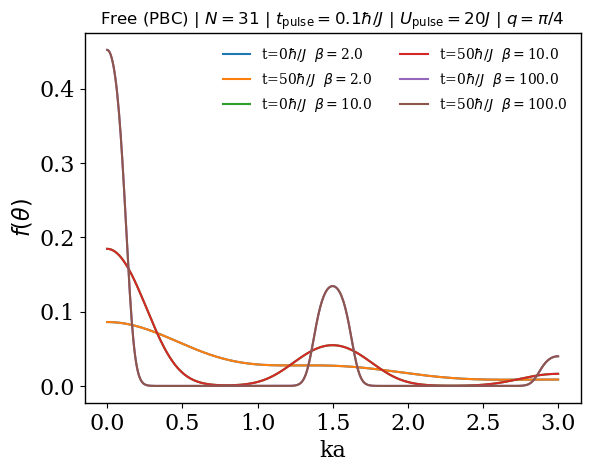

In [7]:
plt.figure()
plt.tight_layout()
temps = [2.0,10.0,100.0]
for b in temps:
    for t in range(0,51,50):
        n = np.fromfile('Bragg_quench/n_free_OBC_L=1000_N=31_t='+str(float(t))+'T='+str(b)+'.bin')
        plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+r'$\hbar/J$  $\beta=$'+str(b))
plt.xlabel('ka',fontsize = 16)
plt.ylabel(r'$f(\theta)$',fontsize = 16)
plt.legend(ncols=2,frameon=False)
plt.tick_params(labelsize=16)
plt.title(r'$\text{Free (OBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

plt.figure()
plt.tight_layout()
temps = [2.0,10.0,100.0]
for b in temps:
    for t in range(0,51,50):
        n = np.fromfile('Bragg_quench/n_trap_L=1000_N=31_t='+str(float(t))+'T='+str(b)+'.bin')
        plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+r'$\hbar/J$  $\beta=$'+str(b))
plt.xlabel('ka',fontsize = 16)
plt.ylabel(r'$f(\theta)$',fontsize = 16)
plt.legend(ncols=2,frameon=False)
plt.tick_params(labelsize=16)
plt.title(r'$\text{Trap (OBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

plt.figure()
plt.tight_layout()
temps = [2.0,10.0,100.0]
for b in temps:
    for t in range(0,51,50):
        n = np.fromfile('Bragg_quench/n_free_L=1000_N=31_t='+str(float(t))+'T='+str(b)+'.bin')
        plt.plot(np.linspace(0,np.pi,501)/(np.pi/3),n,label=r't='+str(t)+r'$\hbar/J$  $\beta=$'+str(b))
plt.xlabel('ka',fontsize = 16)
plt.ylabel(r'$f(\theta)$',fontsize = 16)
plt.legend(ncols=2,frameon=False)
plt.tick_params(labelsize=16)
plt.title(r'$\text{Free (PBC)}\ |\ N=31\ |\ t_{\text{pulse}}=0.1\hbar/J\ |\ U_{\text{pulse}}=20J\ |\ q=\pi/4$')

### Raman-Nath

In [ ]:
def HeavisideTheta(theta,thetaFermi,k,n):
    '''
    Zero temperature Fermi-Dirac distribution.
    '''
    f = 0
    dum = (np.abs(thetaFermi)-np.abs(theta+2*k*n))
    if dum >= 0 :
        f += 1
    else: f+=0
    return f

def KFermi(N,L):
    return np.pi*(N-1)/L

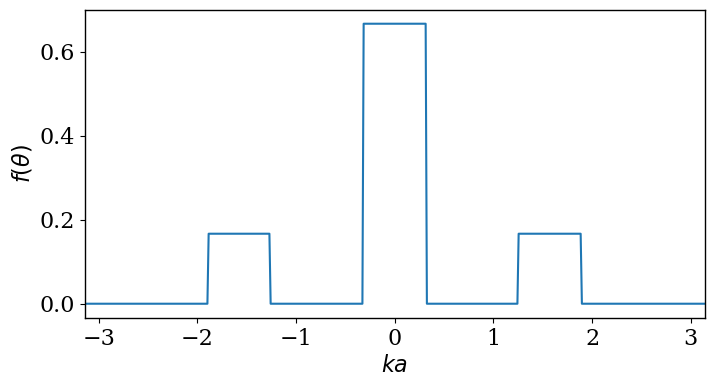

In [18]:
plt.figure(figsize=(8, 4))
plt.tight_layout()
k = np.linspace(-np.pi,np.pi,501)
kF = KFermi(101,1000)

plt.plot(k,[(1/6)*HeavisideTheta(q,kF,np.pi/4,-1) + (4/6)*HeavisideTheta(q,kF,np.pi/4,0) + (1/6)*HeavisideTheta(q,kF,np.pi/4,1)  for q in k])
# plt.plot(k,[(1/6)*HeavisideTheta(q,kF,np.pi/4,-1) + (4/6)*HeavisideTheta(q,kF,np.pi/4,0) + (1/6)*HeavisideTheta(q,kF,np.pi/4,1)  for q in k])
plt.xlim(-np.pi,np.pi)
plt.xlabel('$ka$',fontsize=16)
plt.ylabel(r'$f(\theta)$',fontsize=16)
plt.tick_params(labelsize=16)

###########
### MDF ###
###########
# for t in range(0,1,10):
# t = 0
# P = GaussianMat(101,free_state,bragg_state,bragg_energy,t)
# corr = NCorrMat(P)
# k = np.linspace(0,np.pi,501)
# start_time = time.time()
# n = list(map(lambda q: nkt(q,Length,corr),k))
# end_time = time.time()
# print(end_time-start_time)
# plt.plot(k,n,color='gray',linestyle='--')
# plt.xlabel(r'$\theta$',fontsize=16)
# plt.ylabel(r'$f(\theta)$',fontsize=16)
# plt.tick_params(labelsize=16)
# plt.legend(ncols=5,frameon=False)

In [32]:
np.sum([HeavisideTheta(q,kF) for q in k])
np.sum(n)

(100.99999680377823-1.1827068102952592e-17j)

# Test

In [4]:
import multiprocessing as mp
import pathos.multiprocessing as mpathos

In [33]:

# P = GaussianMat(31,free_state,bragg_state,bragg_energy,time)
# L = Length
# corr = NCorrMat(P)
def MDF(q):
    import functions as func
    import numpy as np
    time=0.5
    trap_state = np.loadtxt('Bragg_quench/trap_eigvec_t=1_g=2_L=1000_PBC.txt').T
    trap_energy = np.loadtxt('Bragg_quench/trap_eigval_t=1_g=2_L=1000_PBC.txt')
    bragg_state = np.loadtxt('Bragg_quench/bragg_eigvec_t=1_L=1000_q=pi10_PBC.txt').T
    bragg_energy = np.loadtxt('Bragg_quench/bragg_eigval_t=1_L=1000_q=pi10_PBC.txt')
    free_state = np.loadtxt('Bragg_quench/free_eigvec_t=1_L=1000_PBC.txt').T
    free_energy = np.loadtxt('Bragg_quench/free_eigval_t=1_L=1000_PBC.txt')
    sites = np.linspace(0,len(free_state[0])-1,len(free_state[0]),dtype=int)
    Length = len(free_energy)
    P = func.GaussianMat(31,free_state,bragg_state,bragg_energy,time)
    L = 1000
    corr = func.NCorrMat(P)
    return func.nkt(q,L,corr)
k = np.linspace(-np.pi,np.pi,1001)
pool = mpathos.Pool(processes=mp.cpu_count(), maxtasksperchild=2)
n = list(pool.imap(MDF,k))
plt.plot(k/(np.pi/5),n,label='t='+str(np.round(time,1)),color='gray')
plt.xlabel('site (i)',fontsize=16)
plt.ylabel(r'$\left\langle \hat{c}_{i}^{\dagger}\hat{c}_{i}\right\rangle$',fontsize=16)
plt.tick_params(labelsize=16)
plt.legend(ncols=5,frameon=False)

KeyboardInterrupt: 

In [28]:
def f(x):
    return x**2

map(f,range(0,10000,10000))

In [16]:
nkt(0,Length,corr)

(0.41858783197436233+1.5720931501039814e-18j)